We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

he IMDB sentiment classification dataset consists of 50,000 movie reviews from IMDB users that are labeled as either positive (1) or negative (0). The reviews are preprocessed and each one is encoded as a sequence of word indexes in the form of integers. The words within the reviews are indexed by their overall frequency within the dataset. For example, the integer “2” encodes the second most frequent word in the data. The 50,000 reviews are split into 25,000 for training and 25,000 for testing.

The dataset was created by researchers at Stanford University and published in a 2011 paper, where they achieved 88.89% accuracy. It was also used within the “Bag of Words Meets Bags of Popcorn” Kaggle competition in 2011.

In [53]:
from keras.datasets import imdb
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, ReLU, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D

import numpy as np
import matplotlib.pyplot as plt

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 5s 0us/step


In [4]:
print('train data ', len(train_data))
print('test data ', len(test_data))


train data  25000
test data  25000


Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [19]:
print(max([max(sequence) for sequence in train_data]))
'''
for sequence in train_data:
    print(max(sequence))'''

9999


'\nfor sequence in train_data:\n    print(max(sequence))'

we can easily map these decode these reviews back to english

In [5]:
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 1s 0us/step


In [14]:
help(word_index.items)

Help on built-in function items:

items(...) method of builtins.dict instance
    D.items() -> a set-like object providing a view on D's items



In [11]:
word_map = dict([(value,key) for (key, value) in word_index.items()])

In [19]:
decoded_review = []
for i in train_data[0]:
    print(word_map.get(i-3))

None
this
film
was
just
brilliant
casting
location
scenery
story
direction
everyone's
really
suited
the
part
they
played
and
you
could
just
imagine
being
there
robert
None
is
an
amazing
actor
and
now
the
same
being
director
None
father
came
from
the
same
scottish
island
as
myself
so
i
loved
the
fact
there
was
a
real
connection
with
this
film
the
witty
remarks
throughout
the
film
were
great
it
was
just
brilliant
so
much
that
i
bought
the
film
as
soon
as
it
was
released
for
None
and
would
recommend
it
to
everyone
to
watch
and
the
fly
fishing
was
amazing
really
cried
at
the
end
it
was
so
sad
and
you
know
what
they
say
if
you
cry
at
a
film
it
must
have
been
good
and
this
definitely
was
also
None
to
the
two
little
boy's
that
played
the
None
of
norman
and
paul
they
were
just
brilliant
children
are
often
left
out
of
the
None
list
i
think
because
the
stars
that
play
them
all
grown
up
are
such
a
big
profile
for
the
whole
film
but
these
children
are
amazing
and
should
be
praised
for
what
they
ha

In [25]:
' '.join([word_map.get(i-3, '-') for i in train_data[0]])

"- this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert - is an amazing actor and now the same being director - father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for - and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also - to the two little boy's that played the - of norman and paul they were just brilliant children are often left out of the - list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### Data preparation

right now the data is in form of list, we need to turn it to tensor. 
we can use one hot encoder, that will convvert them into vectors of 0's and 1's. example: this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as first layer in our network a Dense layer, capable of handling floating point vector data.

In [31]:
# dimensions = 10000
def vectorizing(inputs, dim=10000):
    output= np.zeros((len(inputs), dim))
    for i, inp in enumerate(inputs):
        #giving 1 to all the elements whcich are present in the data
        output[i, inp] = 1
        return output

In [45]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [34]:
x_train = vectorizing(train_data)
x_test = vectorizing(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [46]:
print(x_test.shape)
print(len(y_train))

(25000, 10000)
25000


In [50]:
dd = (x_test[0]- x_test[1])
print(np.where(dd != 0))
print(dd[11])

(array([  11,   12,   15,   16,   17,   19,   20,   21,   22,   29,   30,
         32,   34,   35,   39,   41,   45,   46,   47,   48,   49,   50,
         51,   52,   55,   56,   58,   59,   60,   65,   66,   67,   73,
         85,   88,   89,   92,  100,  104,  105,  108,  109,  111,  114,
        123,  124,  125,  127,  131,  132,  133,  135,  139,  166,  169,
        170,  172,  173,  176,  177,  179,  181,  185,  193,  202,  203,
        220,  221,  229,  238,  252,  270,  273,  286,  290,  292,  299,
        346,  354,  360,  374,  392,  394,  398,  405,  407,  451,  468,
        472,  526,  529,  530,  551,  565,  591,  606,  629,  670,  692,
        717,  818,  841,  861,  875,  878,  921,  943,  950,  976,  987,
        990, 1035, 1069, 1074, 1162, 1193, 1310, 1330, 1429, 1500, 1603,
       1668, 1669, 1732, 1799, 1987, 1988, 2033, 2078, 2352, 2438, 2679,
       2693, 2733, 2801, 2822, 3077, 3127, 3443, 3523, 3639, 3778, 3861,
       3884, 4182, 4378, 4521, 4829, 5045, 5063, 5

In [41]:
model = Sequential()

model.add(Dense(16, activation='relu', input_shape=(10000,)))

# Add one hidden layer 
# after the first layer, you don't need to specify
# the size of the input anymore:
model.add(Dense(16, activation='relu'))


# Add an output layer 
# we used sigmond actication unction here so that the output is probability
# score si between 0 to 1, indicating how likely is teh varible to have red wine or white wine
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [52]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 162us/sample - loss: 0.1637 - acc: 0.9485 - val_loss: 0.2740 - val_acc: 0.8918
Epoch 2/20
15000/15000 [==============================] - 2s 148us/sample - loss: 0.1336 - acc: 0.9588 - val_loss: 0.2822 - val_acc: 0.8892
Epoch 3/20
15000/15000 [==============================] - 2s 147us/sample - loss: 0.1136 - acc: 0.9653 - val_loss: 0.2948 - val_acc: 0.8858
Epoch 4/20
15000/15000 [==============================] - 2s 147us/sample - loss: 0.0907 - acc: 0.9753 - val_loss: 0.3258 - val_acc: 0.8792
Epoch 5/20
15000/15000 [==============================] - 2s 147us/sample - loss: 0.0780 - acc: 0.9780 - val_loss: 0.3257 - val_acc: 0.8824
Epoch 6/20
15000/15000 [==============================] - 2s 149us/sample - loss: 0.0614 - acc: 0.9841 - val_loss: 0.3547 - val_acc: 0.8782
Epoch 7/20
15000/15000 [==============================] - 2s 154us/sample - loss: 0.0491 - acc: 0.9884 - val_l

In [57]:
history_dict = history.history
print(history_dict.keys())

accuracy = history.history['acc']
val_loss = history.history['val_loss']
loss = history.history['loss']
val_acc = history.history['val_acc']

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


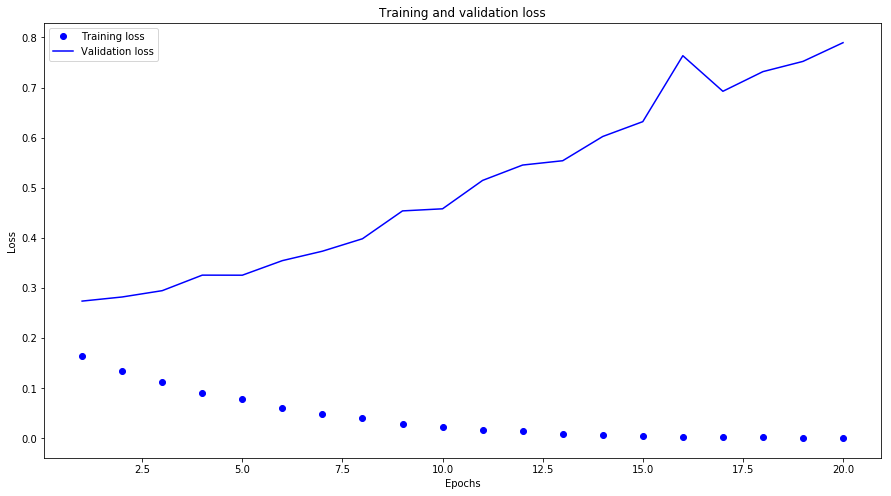

In [59]:
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(15,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

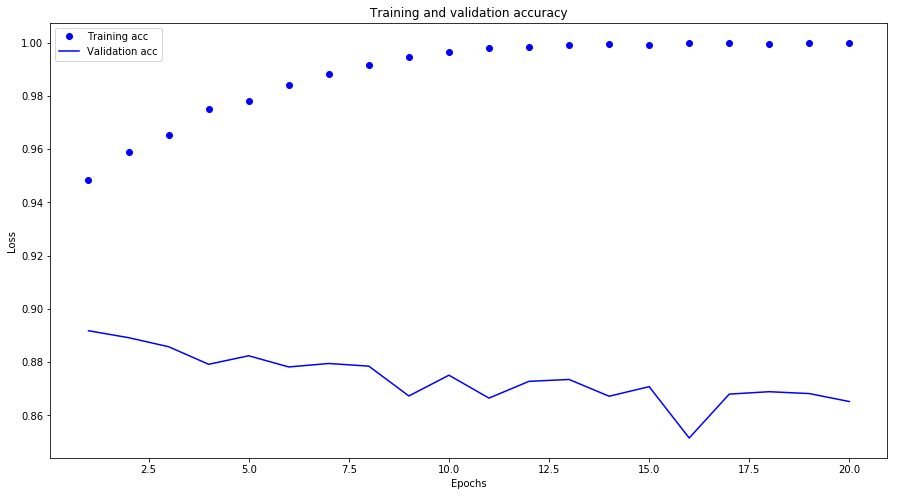

In [61]:
plt.figure(figsize=(15,8))
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()